# Processing

scmdata has some support for processing `ScmRun` instances to calculate statistics of interest. Here we provide examples of how to use them.

## Load some data

For this demonstration, we are going to use MAGICC output from [RCMIP Phase 2] as available at [https://zenodo.org/record/4624566/files/data-processed-submission-database-hadcrut5-target-MAGICCv7.5.1.tar.gz?download=1](). Here we have just extracted the air temperature output for the SSPs from 1995 to 2100.

In [10]:
# NBVAL_IGNORE_OUTPUT
import pandas as pd
import scmdata.processing
from scmdata import ScmRun, run_append

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# NBVAL_IGNORE_OUTPUT
magicc_output = ScmRun("magicc-rcmip-phase-2-gsat-output.csv")
magicc_output

<scmdata.ScmRun (timeseries: 4800, timepoints: 106)>
Time:
	Start: 1995-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	     climate_model  ensemble_member        model region scenario unit  \
	0     MAGICCv7.5.1                0  unspecified  World   ssp585    K   
	1     MAGICCv7.5.1                1  unspecified  World   ssp585    K   
	2     MAGICCv7.5.1                2  unspecified  World   ssp585    K   
	3     MAGICCv7.5.1                3  unspecified  World   ssp585    K   
	4     MAGICCv7.5.1                4  unspecified  World   ssp585    K   
	...            ...              ...          ...    ...      ...  ...   
	4795  MAGICCv7.5.1              595  unspecified  World   ssp119    K   
	4796  MAGICCv7.5.1              596  unspecified  World   ssp119    K   
	4797  MAGICCv7.5.1              597  unspecified  World   ssp119    K   
	4798  MAGICCv7.5.1              598  unspecified  World   ssp119    K   
	4799  MAGICCv7.5.1              599  unspecified  World   ssp119  

## Crossing times

The first thing we do is show how to calculate the crossing times of a given threshold.

In [4]:
# NBVAL_IGNORE_OUTPUT
crossing_time_15 = scmdata.processing.calculate_crossing_times(
    magicc_output, threshold=1.5,
)
crossing_time_15

climate_model  ensemble_member  model        region  scenario  unit  variable                      
MAGICCv7.5.1   0                unspecified  World   ssp585    K     Surface Air Temperature Change    2025.0
               1                unspecified  World   ssp585    K     Surface Air Temperature Change    2029.0
               2                unspecified  World   ssp585    K     Surface Air Temperature Change    2024.0
               3                unspecified  World   ssp585    K     Surface Air Temperature Change    2023.0
               4                unspecified  World   ssp585    K     Surface Air Temperature Change    2023.0
                                                                                                        ...  
               595              unspecified  World   ssp119    K     Surface Air Temperature Change    2023.0
               596              unspecified  World   ssp119    K     Surface Air Temperature Change       NaN
               597  

The output is a `pd.Series`, which is useful for many other pieces of work.

For example, we could make a plot with e.g. seaborn.

<AxesSubplot:xlabel='1.5C crossing time', ylabel='Count'>

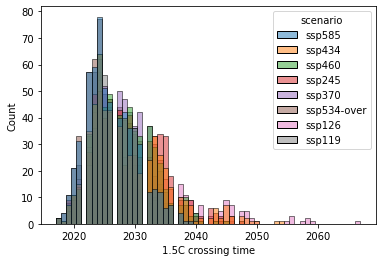

In [5]:
label = "1.5C crossing time"
pdf = crossing_time_15.reset_index().rename({0: label}, axis="columns")
sns.histplot(data=pdf, x=label, hue="scenario")

<AxesSubplot:xlabel='2.0C crossing time', ylabel='Count'>

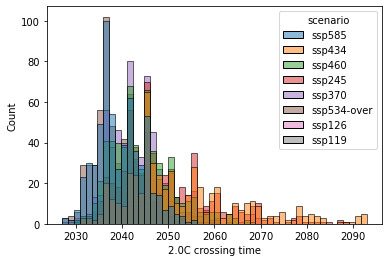

In [6]:
label = "2.0C crossing time"
crossing_time_20 = scmdata.processing.calculate_crossing_times(
    magicc_output, threshold=2.0,
)

pdf = crossing_time_20.reset_index().rename({0: label}, axis="columns")
sns.histplot(data=pdf, x=label, hue="scenario")

### Datetime output

If desired, data could be interpolated first before calculating the crossing times. In such cases, returning the output as datetime rather than year might be helpful.

In [7]:
scmdata.processing.calculate_crossing_times(
    magicc_output.resample("MS"), threshold=2.0, return_year=False,
)

climate_model  ensemble_member  model        region  scenario  unit  variable                      
MAGICCv7.5.1   0                unspecified  World   ssp585    K     Surface Air Temperature Change   2042-02-01
               1                unspecified  World   ssp585    K     Surface Air Temperature Change   2041-10-01
               2                unspecified  World   ssp585    K     Surface Air Temperature Change   2035-11-01
               3                unspecified  World   ssp585    K     Surface Air Temperature Change   2035-09-01
               4                unspecified  World   ssp585    K     Surface Air Temperature Change   2036-01-01
                                                                                                         ...    
               595              unspecified  World   ssp119    K     Surface Air Temperature Change          NaT
               596              unspecified  World   ssp119    K     Surface Air Temperature Change          

## Exceedance probabilities

Next we show how to calculate exceedance probabilities.

In [8]:
exceedance_probability_2C = scmdata.processing.calculate_exceedance_probabilities(
    magicc_output,
    cols="ensemble_member",
    threshold=2.0,
)
exceedance_probability_2C

climate_model  model        region  scenario     unit  variable                      
MAGICCv7.5.1   unspecified  World   ssp119       K     Surface Air Temperature Change    0.091667
                                    ssp126       K     Surface Air Temperature Change    0.350000
                                    ssp245       K     Surface Air Temperature Change    0.995000
                                    ssp370       K     Surface Air Temperature Change    1.000000
                                    ssp434       K     Surface Air Temperature Change    0.868333
                                    ssp460       K     Surface Air Temperature Change    1.000000
                                    ssp534-over  K     Surface Air Temperature Change    0.983333
                                    ssp585       K     Surface Air Temperature Change    1.000000
dtype: float64


We can make a plot to compare exceedance probabilities over multiple scenarios.

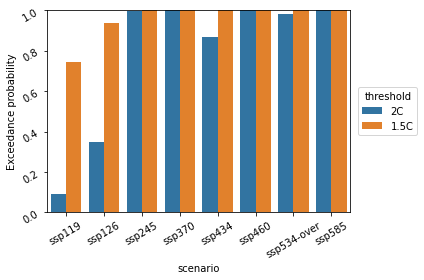

In [11]:
exceedance_probability_15C = scmdata.processing.calculate_exceedance_probabilities(
    magicc_output,
    cols="ensemble_member",
    threshold=1.5,
)


def get_pdf(ins, threshold):
    out = ins.reset_index().rename(
        {0: "Exceedance probability"}, axis="columns"
    )
    out["threshold"] = threshold

    return out


pdf = pd.concat(
    [
        get_pdf(exceedance_probability_2C, "2C"),
        get_pdf(exceedance_probability_15C, "1.5C"),
    ]
)
ax = sns.barplot(
    data=pdf, x="scenario", y="Exceedance probability", hue="threshold"
)
ax.tick_params(labelrotation=30)
ax.set_ylim([0, 1])
ax.legend(loc="center left", bbox_to_anchor=(1.01, 0.5), title="threshold")
plt.tight_layout()

## Exceedance probabilities over time

It is also possible to calculate exceedance probabilities over time.

<AxesSubplot:xlabel='time', ylabel='K'>

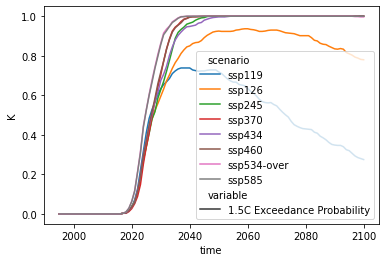

In [12]:
res = scmdata.processing.calculate_exceedance_probabilities_over_time(
    magicc_output,
    cols="ensemble_member",
    threshold=1.5,
).reset_index()
res["variable"] = "1.5C Exceedance Probability"
res = scmdata.ScmRun(res)
res.lineplot(style="variable")

Note that taking the maximum exceedance probability over all time will be less than or equal to the exceedance probability calculated with `calculate_exceedance_probabilities` because the order of operations matters: calculating whether each ensemble member exceeds the threshold or not then seeing how many ensemble members out of the total exceed the threshold is not the same as seeing how many ensemble members exceed the threshold at each timestep and then taking the maximum over all timesteps. In general, taking the maximum value from `calculate_exceedance_probabilities_over_time` will be less than or equal to the results of `calculate_exceedance_probabilities`, as demonstrated below.

In [25]:
(pd.DataFrame(
    {
        "calculate_exceedance_probabilities": exceedance_probability_15C.reset_index(
            ["variable", "unit"], drop=True
        ).reset_index().set_index(["climate_model", "model", "scenario", "region"])[0],
        "max of calculate_exceedance_probabilities_over_time": (
            res.timeseries(meta=["climate_model", "model", "scenario", "region"]).max(axis=1)
        ),
    }
)* 100).round(1)

calculate_exceedance_probabilities  \
climate_model model       scenario    region                                       
MAGICCv7.5.1  unspecified ssp119      World                                 74.3   
                          ssp126      World                                 94.0   
                          ssp245      World                                100.0   
                          ssp370      World                                100.0   
                          ssp434      World                                100.0   
                          ssp460      World                                100.0   
                          ssp534-over World                                100.0   
                          ssp585      World                                100.0   

                                              max of calculate_exceedance_probabilities_over_time  
climate_model model       scenario    region                                                       
MAGICCv7.5.1  unspecified ssp119      World                                                73.8    
                          ssp126      World                                                93.7    
                          ssp245      World                                               100.0    
                          ssp370      World                                               100.0    
                          ssp434      World                                               100.0    
                          ssp460      World                                               100.0    
                          ssp534-over World                                               100.0    
                          ssp585      World                                               100.0